In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from keras.wrappers.scikit_learn import KerasClassifier
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from scipy import interp
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score

In [4]:
AUTO = tf.data.experimental.AUTOTUNE#این کده رو برای کانفیگ تی پی تو کولب استفاده کرده بود و چون تو لرنینگ ریت هم آورده بود منم گفتم بذارم ببینم چی میشه قسمت لرنینک ریت که کلی ارور داد ،
#بدون اون کد رو ران کردم که اگر گفتید کدش بدرد بخوره برم سراغ ارور هاولی این رو که راه کردم سرعت خروجی گرفتنم بهتر شد.ولی واقعا نفهمیدم چی به چیه

# Cluster Resolver for Google Cloud TPUs.
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# Connects to the given cluster.
tf.config.experimental_connect_to_cluster(tpu)
# Initialize the TPU devices.
tf.tpu.experimental.initialize_tpu_system(tpu)
# TPU distribution strategy implementation.
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Configuration
EPOCHS = 50
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Initializing the TPU system: grpc://10.87.154.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.154.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
#loading data
dataset = np.load('data.row/ASD2.npz') #Dataset ready in numpy array (removing background, resizing, and transforming into grayscale)
X = dataset['X']
y = dataset['y']

print(X.shape)
print(y.shape)

(3103, 224, 224, 3)
(3103, 1)


In [6]:
def GetModel():
    resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=True , input_tensor=None, input_shape=None, pooling=None)

    x = resnet50.layers[-2].output
    output = Dense(units=1, activation='sigmoid')(x)
    model = Model(inputs=resnet50.input, outputs=output)
    for layer in model.layers[175:]:
      layer.trainable = True
    for layer in model.layers[:175]:
      layer.trainable = False


    opt = SGD(lr=0.001,momentum=0.99,decay=0.01,nesterov=False)
    #opt = Adam(learning_rate=0.0001,beta_1=0.99,beta_2=0.99,epsilon=0.1,amsgrad=False,name="Adam",)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
#Hyperparameters
nfolds =4
nEpochs = 30
nBatch= 16
#inputDim = X.shape[1] # Count of features

Learning rate schedule: 1e-05 to 0.0004 to 1e-05


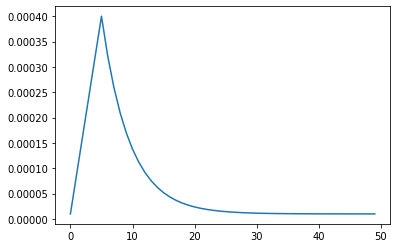

In [14]:
LR_START = 0.00001#اینم اون کدی هست که درباره نرخ یادگیری پیدا کردم.حس کردم توضیحات شما رو پیاده کرده.حالا نمیدونم چقدر درست فهمیده باشم و آیا لازم هست یا نه؟
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
def get_dataset():#اینجا دیگه واقعا گیر کردم اگر کافولد پایین رو بیارم بالا باید فور رو هم بیارم تا ایکس -تست و ایگرگ-تست رو بشناسه
    dataset = np.load('/content/drive/My Drive/data.row.battah/ASD2.npz') #Dataset ready in numpy array (removing background, resizing, and transforming into grayscale)
    X = dataset['X']
    y = dataset['y']

    return dataset

In [8]:
def train_cross_validate(folds = 4):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)
    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1).split(X, y) 
    for train, test in kfold:
        
        model = GetModel()
        history = model.fit(X[train], y[train], callbacks = [ early_stopping], validation_split= 0.2, epochs=nEpochs, batch_size=nBatch, verbose=2)
       
        models.append(model)
        histories.append(history)
        
    return histories, models

In [9]:
histories, models = train_cross_validate()

102973440/102967424 [==============================] - 1s 0us/step
Epoch 1/30


117/117 - 23s - loss: 0.6195 - accuracy: 0.7286 - val_loss: 1.6844 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 20s - loss: 0.5950 - accuracy: 0.7448 - val_loss: 0.9625 - val_accuracy: 0.0107
Epoch 3/30
117/117 - 19s - loss: 0.5646 - accuracy: 0.7469 - val_loss: 1.8156 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 20s - loss: 0.6241 - accuracy: 0.7410 - val_loss: 0.5729 - val_accuracy: 0.9292
Epoch 5/30
117/117 - 20s - loss: 0.6335 - accuracy: 0.7066 - val_loss: 1.3745 - val_accuracy: 0.0021
Epoch 6/30
117/117 - 19s - loss: 0.6083 - accuracy: 0.7039 - val_loss: 1.1474 - val_accuracy: 0.0236
Epoch 7/30
117/117 - 19s - loss: 0.5469 - accuracy: 0.7469 - val_loss: 1.8309 - val_accuracy: 0.0000e+00
Epoch 8/30
117/117 - 19s - loss: 0.5894 - accuracy: 0.7480 - val_loss: 0.9631 - val_accuracy: 0.1330
Epoch 1/30


117/117 - 23s - loss: 0.8673 - accuracy: 0.6169 - val_loss: 2.4469 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 20s - loss: 0.9497 - accuracy: 0.6448 - val_loss: 0.5584 - val_accuracy: 1.0000
Epoch 3/30
117/117 - 19s - loss: 0.6983 - accuracy: 0.6287 - val_loss: 3.3891 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 19s - loss: 0.7970 - accuracy: 0.6276 - val_loss: 1.3478 - val_accuracy: 0.0000e+00
Epoch 5/30
117/117 - 20s - loss: 0.6687 - accuracy: 0.6937 - val_loss: 0.4617 - val_accuracy: 0.9957
Epoch 6/30
117/117 - 19s - loss: 0.6049 - accuracy: 0.7324 - val_loss: 1.7604 - val_accuracy: 0.0000e+00
Epoch 7/30
117/117 - 19s - loss: 0.5840 - accuracy: 0.7480 - val_loss: 0.9306 - val_accuracy: 0.1202
Epoch 8/30
117/117 - 20s - loss: 0.5587 - accuracy: 0.7496 - val_loss: 1.4715 - val_accuracy: 0.0000e+00
Epoch 9/30
117/117 - 19s - loss: 0.5486 - accuracy: 0.7464 - val_loss: 1.5467 - val_accuracy: 0.0000e+00
Epoch 1/30


117/117 - 23s - loss: 0.6889 - accuracy: 0.7028 - val_loss: 0.8474 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 19s - loss: 0.6290 - accuracy: 0.7061 - val_loss: 1.3038 - val_accuracy: 0.0000e+00
Epoch 3/30
117/117 - 19s - loss: 0.5706 - accuracy: 0.7458 - val_loss: 1.5239 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 19s - loss: 0.5616 - accuracy: 0.7480 - val_loss: 1.9164 - val_accuracy: 0.0000e+00
Epoch 5/30
117/117 - 19s - loss: 0.5754 - accuracy: 0.7491 - val_loss: 1.3309 - val_accuracy: 0.0000e+00
Epoch 1/30


117/117 - 23s - loss: 0.7303 - accuracy: 0.6364 - val_loss: 2.5343 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 19s - loss: 0.5886 - accuracy: 0.7449 - val_loss: 1.6349 - val_accuracy: 0.0000e+00
Epoch 3/30
117/117 - 19s - loss: 0.5585 - accuracy: 0.7444 - val_loss: 1.7826 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 19s - loss: 0.5785 - accuracy: 0.7422 - val_loss: 1.9749 - val_accuracy: 0.0000e+00
Epoch 5/30
117/117 - 20s - loss: 0.5929 - accuracy: 0.7186 - val_loss: 0.8379 - val_accuracy: 0.1717
Epoch 6/30
117/117 - 20s - loss: 0.5672 - accuracy: 0.7470 - val_loss: 1.1643 - val_accuracy: 0.0086
Epoch 7/30
117/117 - 20s - loss: 0.5463 - accuracy: 0.7460 - val_loss: 1.1128 - val_accuracy: 0.0215
Epoch 8/30
117/117 - 19s - loss: 0.5497 - accuracy: 0.7481 - val_loss: 1.8175 - val_accuracy: 0.0000e+00
Epoch 9/30
117/117 - 19s - loss: 0.5570 - accuracy: 0.7470 - val_loss: 1.4172 - val_accuracy: 0.0021


In [19]:
def predict(folds = 4):
   histories, models = train_cross_validate(folds = folds)
   scores=[]
   auc =[]


   for i in range(nfolds):
     result = models[i].evaluate(X[test], y[test], verbose=0)
     scores.append(result)
     y_pred = models[i].predict(X[test])
     AUC = roc_auc_score(y[test], y_pred.round())
     auc.append(AUC)  

   return scores,auc   

In [20]:
scores,auc = predict(folds = 4)#اینجا قرار بوده اسکور و اکیوریسی چاپ بشه نمیدونم چرا دوباره از تابع قبل ران کرده(کل ابا تابع هنوز مشکل دارم از سر سی پلاس پلاس ما با هم جور نشدیم)

Epoch 1/30


117/117 - 24s - loss: 0.7643 - accuracy: 0.6706 - val_loss: 3.3798 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 19s - loss: 0.7728 - accuracy: 0.6357 - val_loss: 3.3955 - val_accuracy: 0.0000e+00
Epoch 3/30
117/117 - 19s - loss: 0.6410 - accuracy: 0.7055 - val_loss: 0.9338 - val_accuracy: 0.0622
Epoch 4/30
117/117 - 19s - loss: 0.5512 - accuracy: 0.7512 - val_loss: 1.2286 - val_accuracy: 0.0107
Epoch 5/30
117/117 - 19s - loss: 0.5615 - accuracy: 0.7474 - val_loss: 0.9267 - val_accuracy: 0.1266
Epoch 6/30
117/117 - 19s - loss: 0.5585 - accuracy: 0.7480 - val_loss: 0.9429 - val_accuracy: 0.1288
Epoch 7/30
117/117 - 19s - loss: 0.5729 - accuracy: 0.7501 - val_loss: 1.6934 - val_accuracy: 0.0000e+00
Epoch 8/30
117/117 - 19s - loss: 0.5460 - accuracy: 0.7469 - val_loss: 1.3116 - val_accuracy: 0.0172
Epoch 9/30
117/117 - 19s - loss: 0.5441 - accuracy: 0.7491 - val_loss: 0.9412 - val_accuracy: 0.1674
Epoch 1/30


117/117 - 23s - loss: 0.9547 - accuracy: 0.6142 - val_loss: 0.1934 - val_accuracy: 1.0000
Epoch 2/30
117/117 - 20s - loss: 1.1454 - accuracy: 0.6153 - val_loss: 4.6943 - val_accuracy: 0.0000e+00
Epoch 3/30
117/117 - 20s - loss: 1.0100 - accuracy: 0.6104 - val_loss: 2.5993 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 20s - loss: 0.8799 - accuracy: 0.6158 - val_loss: 1.4513 - val_accuracy: 0.0000e+00
Epoch 5/30
117/117 - 19s - loss: 0.6687 - accuracy: 0.7023 - val_loss: 0.5649 - val_accuracy: 0.9270
Epoch 1/30


117/117 - 23s - loss: 0.6895 - accuracy: 0.6690 - val_loss: 0.8966 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 20s - loss: 0.7545 - accuracy: 0.6411 - val_loss: 0.3461 - val_accuracy: 1.0000
Epoch 3/30
117/117 - 19s - loss: 0.6220 - accuracy: 0.7184 - val_loss: 1.5681 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 20s - loss: 0.5522 - accuracy: 0.7458 - val_loss: 1.4611 - val_accuracy: 0.0000e+00
Epoch 5/30
117/117 - 19s - loss: 0.5634 - accuracy: 0.7507 - val_loss: 1.8728 - val_accuracy: 0.0000e+00
Epoch 6/30
117/117 - 19s - loss: 0.5498 - accuracy: 0.7491 - val_loss: 1.4825 - val_accuracy: 0.0000e+00
Epoch 1/30


117/117 - 23s - loss: 0.6746 - accuracy: 0.7132 - val_loss: 2.4008 - val_accuracy: 0.0000e+00
Epoch 2/30
117/117 - 19s - loss: 0.7165 - accuracy: 0.6869 - val_loss: 1.3308 - val_accuracy: 0.0000e+00
Epoch 3/30
117/117 - 20s - loss: 0.5687 - accuracy: 0.7465 - val_loss: 1.1108 - val_accuracy: 0.0000e+00
Epoch 4/30
117/117 - 19s - loss: 0.5765 - accuracy: 0.7492 - val_loss: 0.8731 - val_accuracy: 0.1266
Epoch 5/30
117/117 - 19s - loss: 0.5595 - accuracy: 0.7470 - val_loss: 1.1276 - val_accuracy: 0.0086
Epoch 6/30
117/117 - 20s - loss: 0.6020 - accuracy: 0.7218 - val_loss: 1.6760 - val_accuracy: 0.0000e+00
Epoch 7/30
117/117 - 20s - loss: 0.5550 - accuracy: 0.7508 - val_loss: 1.3338 - val_accuracy: 0.0021
Epoch 8/30
117/117 - 20s - loss: 0.5470 - accuracy: 0.7454 - val_loss: 1.1166 - val_accuracy: 0.0258


NameError: ignored